In [26]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

In [27]:
df = pd.read_csv('./data/dataset/weatherHistory.csv')
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [28]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']
univariate_df.head()

Formatted Date
2006-04-01 00:00:00.000 +0200    9.472222
2006-04-01 01:00:00.000 +0200    9.355556
2006-04-01 02:00:00.000 +0200    9.377778
2006-04-01 03:00:00.000 +0200    8.288889
2006-04-01 04:00:00.000 +0200    8.755556
Name: Temperature (C), dtype: float64

In [29]:
# có thể xem offset như là stride (bước nhảy)
def slicing_window(data:pd.DataFrame,feature_size:int, label_size: int, offset: int):
    x, y = [], []
    for i in range(0, len(data) - feature_size - label_size + 1, offset):
        x.append(data.iloc[i:i+feature_size])
        y.append(data.iloc[i+feature_size:i+feature_size+label_size])

    return x, y


In [53]:
train_size = 0.7
val_size = 0.2
input_size = 6
output_size = 1
offset = 1

X_train, y_train = slicing_window(
    univariate_df, input_size, output_size, offset
)

X_val, y_val = slicing_window(
    univariate_df, input_size, output_size, offset
)

X_test, y_test = slicing_window(
    univariate_df, input_size, output_size, offset
)

In [55]:
class WeatherForecastDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [56]:
train_dataset = WeatherForecastDataset(
    X_train, y_train
)
val_dataset = WeatherForecastDataset(
    X_val, y_val
)
test_dataset = WeatherForecastDataset(
    X_test, y_test
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [57]:
train_iter = iter(train_loader)
train_batch = next(train_iter)

# Kiểm tra nội dung của batch
inputs, labels = train_batch  # Giả sử dataset trả về (inputs, labels)
print("Inputs shape:", inputs.shape)
print("Labels shape:", labels.shape)

Inputs shape: torch.Size([128, 6])
Labels shape: torch.Size([128, 1])


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2868\1179353847.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [69]:
class WeatherForecastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size,
                          n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = self.norm(x)

        # tắt đi 1 dim của hidden_size giúp model học tốt hơn 
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [70]:
n_layers = 3
dropout_prob = 0.2

embedding_dim = 6
hidden_size = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(
    embedding_dim = embedding_dim,
    hidden_size = hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)

In [71]:
lr = 1e-3
epochs = 50
critertion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [74]:
def fit(
    model, train_loader, val_loader, criterion, optimizer, epochs, device
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (texts, labels) in enumerate(train_loader):
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        val_loss = evaluate(model, val_loader, criterion, device)

        train_losses.append(np.mean(batch_train_losses))
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}: \tTrain loss: {np.mean(batch_train_losses):.4f} \tVal loss: {val_loss:.4f}"
        )

    return train_losses, val_losses


def evaluate(model, data_loader, criterion, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for idx, (texts, labels) in enumerate(data_loader):
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            losses.append(loss.item())

    losses = np.mean(losses)

    return losses

In [76]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    critertion,
    optimizer,
    epochs,
    device,
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2868\1179353847.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


EPOCH 1: 	Train loss: 4.9297 	Val loss: 2.2316
EPOCH 2: 	Train loss: 4.8246 	Val loss: 2.1541
EPOCH 3: 	Train loss: 4.8577 	Val loss: 2.0998
EPOCH 4: 	Train loss: 4.8331 	Val loss: 2.1934
EPOCH 5: 	Train loss: 4.8619 	Val loss: 2.4735
EPOCH 6: 	Train loss: 4.8338 	Val loss: 2.5596
EPOCH 7: 	Train loss: 4.8211 	Val loss: 2.1471
EPOCH 8: 	Train loss: 4.8055 	Val loss: 2.2004
EPOCH 9: 	Train loss: 4.7822 	Val loss: 2.1833
EPOCH 10: 	Train loss: 4.8096 	Val loss: 2.0731
EPOCH 11: 	Train loss: 4.8103 	Val loss: 2.2125
EPOCH 12: 	Train loss: 4.8134 	Val loss: 2.0643
EPOCH 13: 	Train loss: 4.8653 	Val loss: 2.0500
EPOCH 14: 	Train loss: 4.7818 	Val loss: 2.1136
EPOCH 15: 	Train loss: 4.8862 	Val loss: 2.2693
EPOCH 16: 	Train loss: 4.8107 	Val loss: 2.1602
EPOCH 17: 	Train loss: 4.7810 	Val loss: 2.2862
EPOCH 18: 	Train loss: 4.8340 	Val loss: 2.1377
EPOCH 19: 	Train loss: 4.7580 	Val loss: 2.0350
EPOCH 20: 	Train loss: 4.8828 	Val loss: 2.2515
EPOCH 21: 	Train loss: 4.8975 	Val loss: 2.0972
E

In [77]:
val_loss = evaluate(
    model,
    val_loader,
    critertion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    critertion,
    device
)

print('Evaluation on val / test dataset')
print('Val accuracy:', val_loss)
print('Test accuracy:', test_loss)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2868\1179353847.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Evaluation on val / test dataset
Val accuracy: 2.0521462770795678
Test accuracy: 2.0521462770795678


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2868\513158560.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)


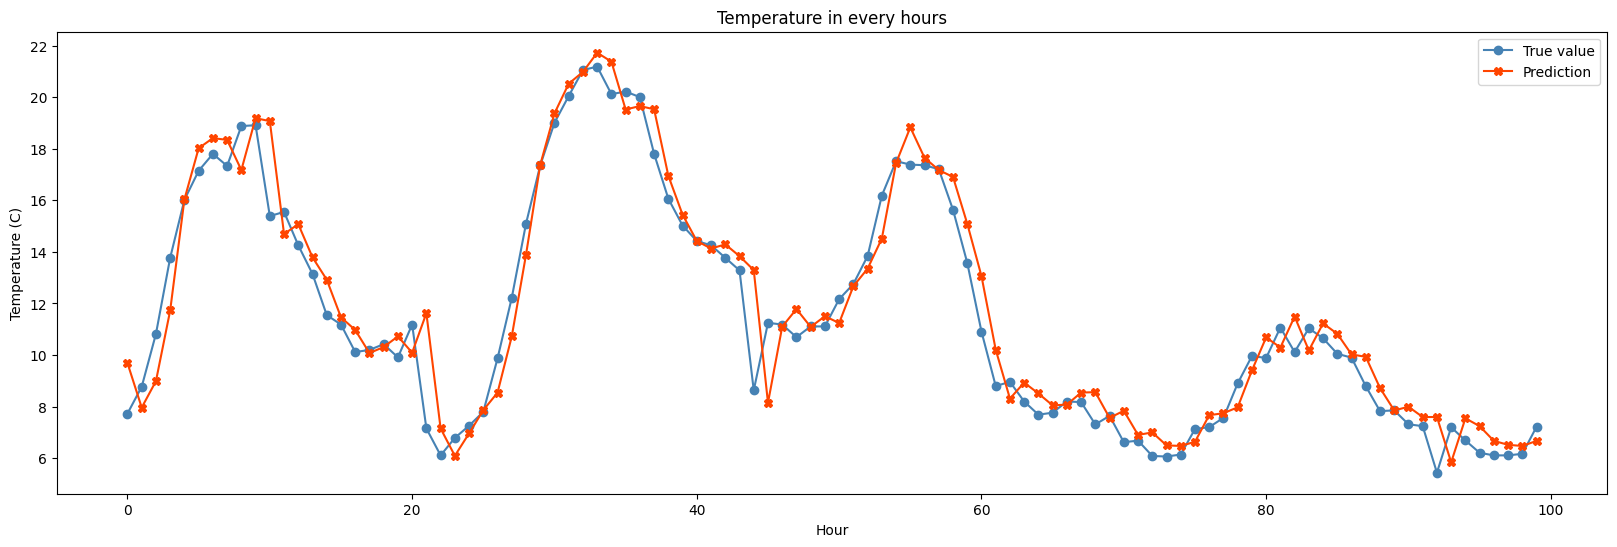

In [79]:
import numpy as np

def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))

    # Chuyển y và pred thành NumPy arrays nếu chúng là list
    y_to_plot = np.array(y).flatten()  # Làm phẳng y
    pred_to_plot = np.array(pred).flatten()  # Làm phẳng pred

    plt.plot(times, y_to_plot, color='steelblue',
             marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered',
             marker='X', label='Prediction')

    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()


# Giả sử X_test và y_test là các list hoặc NumPy arrays, cần chuyển đổi nếu cần
inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()

# Cập nhật y_test cho đúng định dạng
y_test = np.array(y_test)  # Đảm bảo y_test là NumPy array nếu nó là list

plot_difference(y_test[:100], outputs)